In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")  # Go up one directory level

from src.torch_utils import TransformDataset, create_dataloaders, create_dataloaders_with_transforms, train_model, evaluate_model, plot_training_history, visualize_model_evaluation

In [2]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from tqdm import tqdm
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import (
    Subset,
    random_split,
    DataLoader,
    TensorDataset
)

seed = 7
generator = torch.Generator().manual_seed(7)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
generator = torch.Generator().manual_seed(seed)

In [3]:
print(f"Is MPS available: {torch.backends.mps.is_available()}")
print(f"MPS device exists: {torch.backends.mps.is_built()}")

Is MPS available: True
MPS device exists: True


In [14]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


## Prepare Data Directories

In [4]:
base_path = "../data/dogs-vs-cats-all/"

In [5]:
os.makedirs(os.path.join(base_path, "working/train"), exist_ok=True)
os.makedirs(os.path.join(base_path, "working/train/dogs"), exist_ok=True)
os.makedirs(os.path.join(base_path, "working/train/cats"), exist_ok=True)

In [6]:
for train_img in os.listdir(os.path.join(base_path, "train")):
    src = os.path.join(base_path, "train", train_img)
    
    if train_img.startswith("dog"):
        dst = os.path.join(base_path, "working/train/dogs", train_img)
    elif train_img.startswith("cat"):
        dst = os.path.join(base_path, "working/train/cats", train_img)
    
    os.rename(src, dst)

## Create DataLoaders

In [7]:
# IMAGE_SIZE = 150
# BATCH_SIZE = 64

In [8]:
IMAGE_SIZE = 150

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(os.path.join(base_path, "working/train"), transform=transform)

subset_size = 1000
full_size = len(dataset)

subset_indices = random.sample(range(full_size), subset_size)
subset_dataset = Subset(dataset, subset_indices)

BATCH_SIZE = 64

train_loader, val_loader, test_loader = create_dataloaders(
    dataset=subset_dataset,
    batch_size=BATCH_SIZE,
    val_split=0.2, 
    test_split=0.2,
    random_seed=seed,
    pin_memory=False
)

## Train Model: Two-Stage Approach
- Extracts features first, then trains classifier
- Data augmentation not possible here

### Feature Extraction

In [10]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

summary(vgg16, input_size=(1, 3, IMAGE_SIZE, IMAGE_SIZE))

/Users/kate/Documents/repos/ml-boilerplate/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kate/Documents/repos/ml-boilerplate/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 150, 150]         1,792
│    └─ReLU: 2-2                         [1, 64, 150, 150]         --
│    └─Conv2d: 2-3                       [1, 64, 150, 150]         36,928
│    └─ReLU: 2-4                         [1, 64, 150, 150]         --
│    └─MaxPool2d: 2-5                    [1, 64, 75, 75]           --
│    └─Conv2d: 2-6                       [1, 128, 75, 75]          73,856
│    └─ReLU: 2-7                         [1, 128, 75, 75]          --
│    └─Conv2d: 2-8                       [1, 128, 75, 75]          147,584
│    └─ReLU: 2-9                         [1, 128, 75, 75]          --
│    └─MaxPool2d: 2-10                   [1, 128, 37, 37]          --
│    └─Conv2d: 2-11                      [1, 256, 37, 37]          29

In [11]:
feature_extractor = vgg16.features.to(DEVICE)
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [12]:
def extract_features(dataloader, feature_extractor, device):
    """Extract features from images using pretrained model"""
    
    num_samples = len(dataloader.dataset)
    
    sample_batch, _ = next(iter(dataloader))
    sample_input = sample_batch[0:1].to(device)
    
    with torch.no_grad():
        sample_output = feature_extractor(sample_input)
        
    _, num_channels, height, width = sample_output.shape
    print(f"Feature shape from pretrained model: {sample_output.shape} for input shape {sample_input.shape}")
    
    features = torch.zeros((num_samples, num_channels, height, width))
    labels = torch.zeros(num_samples)
    
    new_dataloader = DataLoader(
        dataloader.dataset,
        batch_size=dataloader.batch_size,
        shuffle=False
    )
    
    count = 0
    with torch.no_grad():
        for inputs, targets in tqdm(new_dataloader):
            batch_size = min(inputs.size(0), num_samples - count)
            if batch_size <= 0:
                break
                
            batch_features = feature_extractor(inputs[:batch_size].to(device))
            features[count:count+batch_size] = batch_features.cpu()
            labels[count:count+batch_size] = targets[:batch_size]
            count += batch_size
    
    feature_dim = num_channels * height * width
    features_flat = features.view(num_samples, feature_dim)
    
    return features_flat, labels

In [13]:
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)
test_size = len(test_loader.dataset)

train_features, train_labels = extract_features(train_loader, feature_extractor, DEVICE)
val_features, val_labels = extract_features(val_loader, feature_extractor, DEVICE)
test_features, test_labels = extract_features(test_loader, feature_extractor, DEVICE)

Feature shape from pretrained model: torch.Size([1, 512, 4, 4]) for input shape torch.Size([1, 3, 150, 150])


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Feature shape from pretrained model: torch.Size([1, 512, 4, 4]) for input shape torch.Size([1, 3, 150, 150])


100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


Feature shape from pretrained model: torch.Size([1, 512, 4, 4]) for input shape torch.Size([1, 3, 150, 150])


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


### Classifier Training

In [14]:
train_dataset = TensorDataset(train_features, train_labels.unsqueeze(1))
val_dataset = TensorDataset(val_features, val_labels.unsqueeze(1))
test_dataset = TensorDataset(test_features, test_labels.unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_rate=0.3):
        super(SimpleClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.classifier(x)

In [16]:
LEARNING_RATE = 2e-5

input_dim = train_features.size(1)
model = SimpleClassifier(input_dim).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

history, trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10,
)


Epoch 1/10
--------------------


Epoch 1/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 10.36it/s, loss=0.2612, acc=0.9313]


Train Loss: 0.3782 | Train Acc: 0.8672
Val Loss: 0.2612 | Val Acc: 0.9313
New best model (val_loss: 0.2612)

Epoch 2/10
--------------------


Epoch 2/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 218.07it/s, loss=0.2258, acc=0.9062]


Train Loss: 0.1893 | Train Acc: 0.9594
Val Loss: 0.2258 | Val Acc: 0.9062
New best model (val_loss: 0.2258)

Epoch 3/10
--------------------


Epoch 3/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 344.19it/s, loss=0.2092, acc=0.9062]


Train Loss: 0.1441 | Train Acc: 0.9641
Val Loss: 0.2092 | Val Acc: 0.9062
New best model (val_loss: 0.2092)

Epoch 4/10
--------------------


Epoch 4/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 293.42it/s, loss=0.1961, acc=0.9125]


Train Loss: 0.1173 | Train Acc: 0.9766
Val Loss: 0.1961 | Val Acc: 0.9125
New best model (val_loss: 0.1961)

Epoch 5/10
--------------------


Epoch 5/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 313.74it/s, loss=0.1913, acc=0.9062]


Train Loss: 0.1037 | Train Acc: 0.9797
Val Loss: 0.1913 | Val Acc: 0.9062
New best model (val_loss: 0.1913)

Epoch 6/10
--------------------


Epoch 6/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 317.49it/s, loss=0.1843, acc=0.9187]


Train Loss: 0.0884 | Train Acc: 0.9906
Val Loss: 0.1843 | Val Acc: 0.9187
New best model (val_loss: 0.1843)

Epoch 7/10
--------------------


Epoch 7/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 342.35it/s, loss=0.1926, acc=0.9125]


Train Loss: 0.0773 | Train Acc: 0.9875
Val Loss: 0.1926 | Val Acc: 0.9125

Epoch 8/10
--------------------


Epoch 8/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 303.82it/s, loss=0.1810, acc=0.9187]


Train Loss: 0.0701 | Train Acc: 0.9891
Val Loss: 0.1810 | Val Acc: 0.9187
New best model (val_loss: 0.1810)

Epoch 9/10
--------------------


Epoch 9/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 312.21it/s, loss=0.1767, acc=0.9250]


Train Loss: 0.0611 | Train Acc: 0.9906
Val Loss: 0.1767 | Val Acc: 0.9250
New best model (val_loss: 0.1767)

Epoch 10/10
--------------------


Epoch 10/10 [Val]: 100%|██████████| 3/3 [00:00<00:00, 304.41it/s, loss=0.1763, acc=0.9250]


Train Loss: 0.0578 | Train Acc: 0.9922
Val Loss: 0.1763 | Val Acc: 0.9250
New best model (val_loss: 0.1763)

Training completed in 0m 1s
Best validation loss: 0.1763


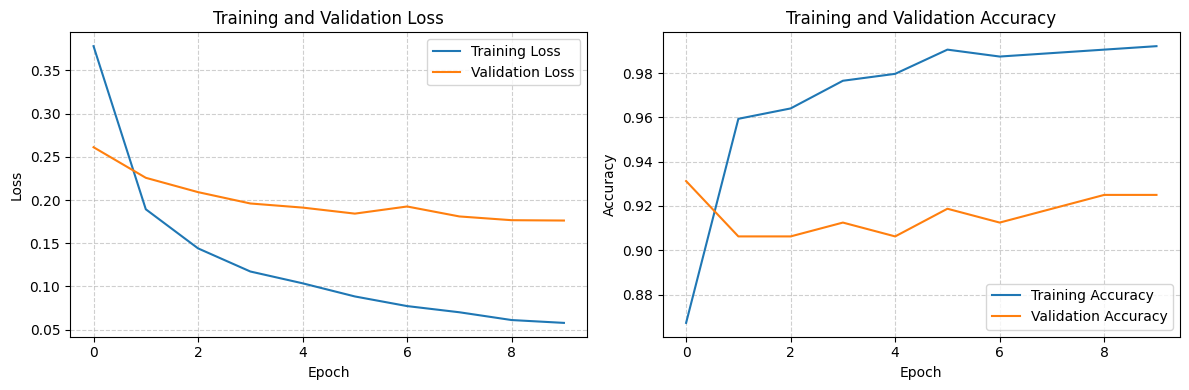

In [17]:
plot_training_history(history)

In [18]:
eval_metrics = evaluate_model(
    model=trained_model,
    test_loader=test_loader,
    criterion=criterion, 
    device=DEVICE, 
)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 82.39it/s]


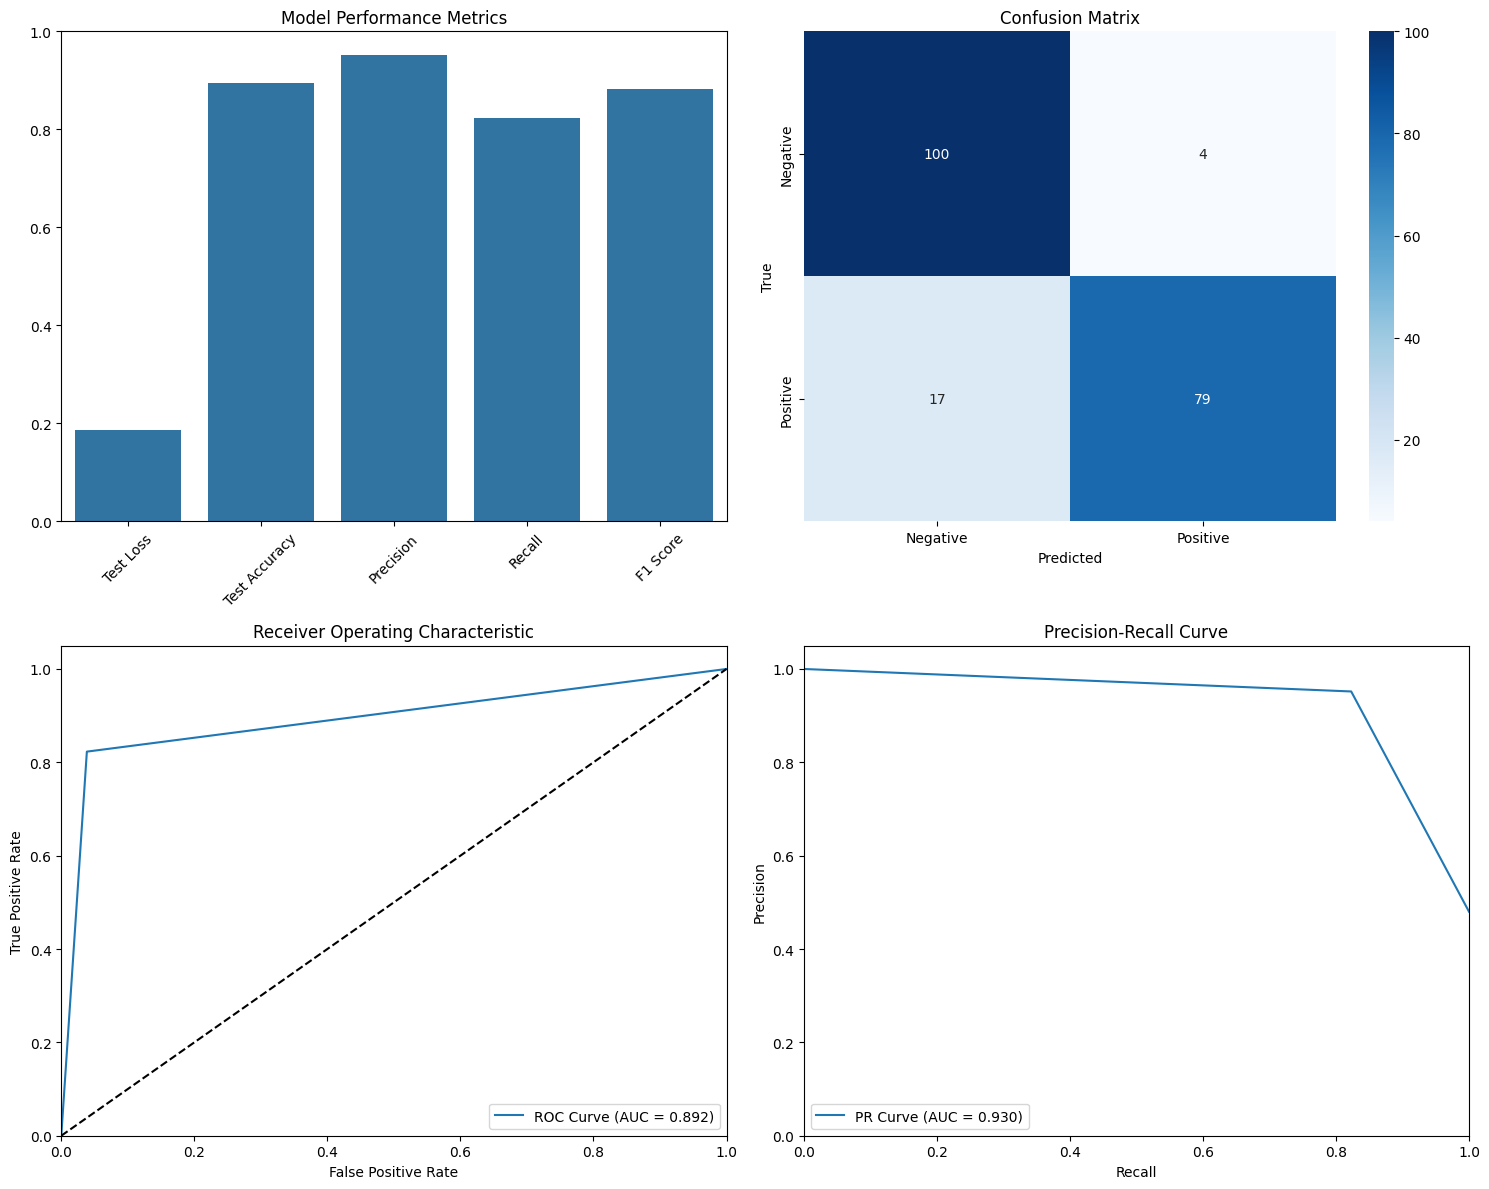

{'Test Loss': 0.18693989519029855,
 'Test Accuracy': 0.895,
 'Precision': 0.9518072289156626,
 'Recall': 0.8229166666666666,
 'F1 Score': 0.88268156424581}

In [19]:
visualize_model_evaluation(eval_metrics)

## Train Model: End-to-End Approach
- Trains on raw images with VGG16 feature extraction during each epoch
- Uses data augmentation for better generalization
- More computationally intensive but more memory efficient

In [11]:
vgg16 = models.vgg16(pretrained=True)
feature_extractor = vgg16.features

In [12]:
class EndToEndModel(nn.Module):
    def __init__(self, feature_extractor, hidden_dim=256, dropout_rate=0.3):
        super(EndToEndModel, self).__init__()
        self.feature_extractor = feature_extractor
        
        sample_input = torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE)
        
        with torch.no_grad():
            sample_output = self.feature_extractor(sample_input)
        
        feature_size = sample_output.numel()
        print(f"Feature shape from pretrained model: {sample_output.shape} for input shape {sample_input.shape}")
        print(f"Flattened feature size: {feature_size}")
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

### Data Augmentation

In [5]:
IMAGE_SIZE = 150

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    # transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(os.path.join(base_path, "working/train"), transform=transform)

subset_size = 1000
full_size = len(dataset)

subset_indices = random.sample(range(full_size), subset_size)
subset_dataset = Subset(dataset, subset_indices)

BATCH_SIZE = 64
train_loader, val_loader, test_loader = create_dataloaders_with_transforms(
    dataset=subset_dataset,
    batch_size=BATCH_SIZE,
    train_transform=train_transform,
    val_transform=val_test_transform,
    test_transform=val_test_transform,
    val_split=0.2, 
    test_split=0.2,
    random_seed=seed,
    pin_memory=False
)

In [ ]:
LEARNING_RATE = 2e-5

model = EndToEndModel(feature_extractor).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

history, trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=3,
)

In [ ]:
plot_training_history(history)

In [ ]:
eval_metrics = evaluate_model(
    model=trained_model,
    test_loader=test_loader,
    criterion=criterion, 
    device=DEVICE, 
)